In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import datetime
import requests
import re
import matplotlib.ticker as ticker
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
import time
from scipy.stats import skew, kurtosis
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
api_key = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
ticker = "SPY240802C00530000"
from scipy.stats import kurtosis, skew
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError

In [2]:
date = "2024-04-03"
type ="P"
strike = 519

In [3]:
# Define US holidays for the year 2024
us_holidays = holidays.US(years=2024)

# Function to calculate the next working day
def next_working_day(date):
    next_day = date + timedelta(days=1)
    
    # Check if the next day is a weekend or holiday and adjust accordingly
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    
    return next_day
next_work = datetime.strptime(date, '%Y-%m-%d')
next_working_date = next_working_day(next_work)

In [4]:
# Function to calculate the next working day
def next_working_day(date):
    next_day = date + timedelta(days=1)
    
    # Check if the next day is a weekend or holiday and adjust accordingly
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    
    return next_day

# Calculate the next working day
next_work = datetime.strptime(date, '%Y-%m-%d')
next_working_date = next_working_day(next_work)
expiration_date = next_working_date.strftime("%y%m%d")

# Print the result
print(f"Trading Date: {date}")
print(f"Expiration Date: {next_working_date.strftime('%Y-%m-%d')}")


# Function to replace the strike value in the given string
def replace_strike(symbol, strike, expiration_date):
    # Format the strike value to be 8 digits long, padded with zeros
    formatted_strike = f"{strike * 1000:08d}"  # Multiply by 1000 to get the correct format
    # Construct the new symbol
    new_symbol = f"SPY{expiration_date}{type}{formatted_strike}"
    return new_symbol
expiration_date = next_working_date.strftime("%y%m%d")
# Replace the date and strike in the ticker
ticker = replace_strike(ticker, strike, expiration_date)
print(f"Ticker: {ticker}")

Trading Date: 2024-04-03
Expiration Date: 2024-04-04
Ticker: SPY240404P00519000


In [5]:
def get_option_price(ticker, date):
    # Convert the date to the correct format (YYYY-MM-DD)
    API_KEY = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
    url = f"https://api.polygon.io/v1/open-close/O:{ticker}/{date}?adjusted=true&apiKey={API_KEY}"
    print(url)  # For debugging purposes
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            data = response.json()
            if 'close' in data:
                return data['close']
            else:
                raise ValueError("Response JSON does not contain 'close' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [6]:
open_trade_price = get_option_price(ticker, date) *100
close_trade_date = next_working_date.date() 
close_trade_price = get_option_price(ticker, close_trade_date) *100
beneficio = close_trade_price - open_trade_price
perc = beneficio*100/open_trade_price
beneficio = round(beneficio,0)
perc = round(perc,0) 
print(f"Precio de apertura: {open_trade_price}")
print(f"Precio de cierre  : {close_trade_price}")
print(f"Beneficio: {beneficio}$- {perc}%")

https://api.polygon.io/v1/open-close/O:SPY240404P00519000/2024-04-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
https://api.polygon.io/v1/open-close/O:SPY240404P00519000/2024-04-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Precio de apertura: 73.0
Precio de cierre  : 573.0
Beneficio: 500.0$- 685.0%


In [7]:

def get_history_price(ticker, date, expiration_day):
    # Convert the date and expiration_day to the correct format (YYYY-MM-DD)
    API_KEY = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
    url = f"https://api.polygon.io/v2/aggs/ticker/O:{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    print(url)  # For debugging purposes
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            data = response.json()
            return data  # Return the full data as it may contain multiple entries
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [8]:
def get_history_price(ticker, date, expiration_day):
    # Convert the date and expiration_day to the correct format (YYYY-MM-DD)
    API_KEY = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
    url = f"https://api.polygon.io/v2/aggs/ticker/O:{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    print(url)  # For debugging purposes
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            data = response.json()
            # Extract necessary data and create a DataFrame
            if 'results' in data:
                results = data['results']
                df = pd.DataFrame(results)
                df = df.rename(columns={'t': 'timestamp', 'o': 'open', 'c': 'close', 'l': 'low', 'h': 'high'})
                return df[['timestamp', 'open', 'close', 'low', 'high']]
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [11]:
closing_day = next_working_date.date()


In [12]:
option_data = get_history_price(ticker, date, closing_day)

https://api.polygon.io/v2/aggs/ticker/O:SPY240404P00519000/range/1/minute/2024-04-03/2024-04-04?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF


In [13]:
option_data['human_dates'] = option_data['timestamp'].apply(lambda ts: datetime.fromtimestamp(ts / 1000).strftime('%Y-%m-%d %H:%M:%S'))

In [18]:
option_data.head(40)

,timestamp,open,close,low,high,human_dates
0,1712151000000,2.25,2.26,2.07,2.26,2024-04-03 15:30:00
1,1712151060000,2.25,2.08,2.07,2.25,2024-04-03 15:31:00
2,1712151120000,2.07,1.92,1.88,2.09,2024-04-03 15:32:00
3,1712151180000,1.94,1.98,1.92,2.04,2024-04-03 15:33:00
4,1712151240000,1.99,1.95,1.95,1.99,2024-04-03 15:34:00
5,1712151300000,1.96,1.95,1.95,1.97,2024-04-03 15:35:00
6,1712151360000,1.95,1.81,1.79,1.95,2024-04-03 15:36:00
7,1712151420000,1.84,1.78,1.78,1.88,2024-04-03 15:37:00
8,1712151480000,1.76,1.86,1.76,1.88,2024-04-03 15:38:00
9,1712151540000,1.88,1.81,1.78,1.88,2024-04-03 15:39:00


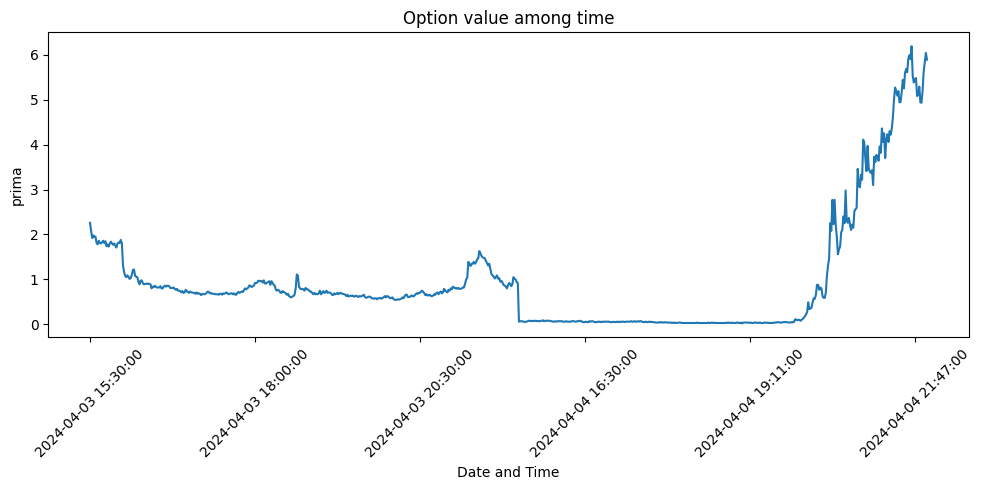

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(option_data['human_dates'], option_data['close'])

# Adding titles and labels
plt.title('Option value among time')
plt.xlabel('Date and Time')
plt.ylabel('prima')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Limit the number of x-ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

# Show the plot
plt.tight_layout()
plt.show()